In [1]:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import itertools
import collections
import pandas as pd
import networkx as nx

In [2]:
N = 5
M = 30
ticks = 11

In [155]:
rnd = np.random.RandomState(1)

In [156]:
D = np.round(np.linspace(0.0,1,ticks),4)

In [157]:
D

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [158]:
m_center = np.round(rnd.rand(M,N),2)
m_min = np.round(rnd.rand(M,N)*m_center,2)
m_max = np.round(m_center + rnd.rand(M,N)*(1-m_center),2)

In [159]:
A = np.zeros((M, N, ticks))

In [160]:
for i in range(M):
    for j in range(N):
        for t in range(ticks):
            if m_min[i,j] < D[t] < m_center[i,j]:
                A[i,j,t] = (D[t] - m_min[i,j]) / (m_center[i,j] - m_min[i,j])
            elif m_center[i,j] <= D[t] < m_max[i,j]:
                A[i,j,t] = (m_max[i,j] - D[t] ) / (m_max[i,j] - m_center[i,j])

In [286]:
#for i in range(M):
#    for j in range(N):
#        for t in range(1, ticks-1):
#            if m_min[i,j] < D[t] < m_center[i,j]:
#                A[i,j,t] = np.round(rnd.uniform(A[i,j,t-1], A[i,j,t+1]), 2)
#            elif m_center[i,j] <= D[t] < m_max[i,j]:
#               A[i,j,t] = np.round(rnd.uniform(A[i,j,t+1], A[i,j,t-1]), 2)

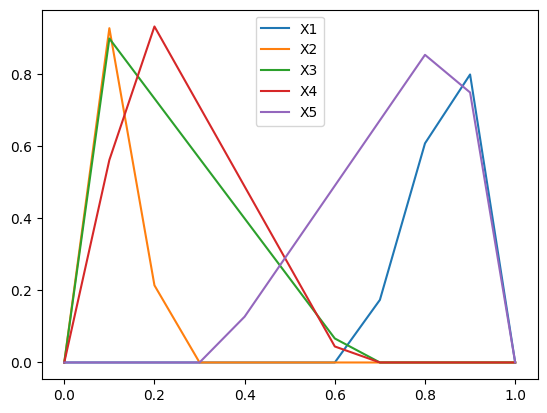

In [161]:
ax = plt.subplot(1,1,1)
for j in range(N):
    ax.plot(D, A[5,j], label= f"X{j+1}")
ax.legend()
plt.savefig("fig_x5.png", dpi=600)
plt.show()

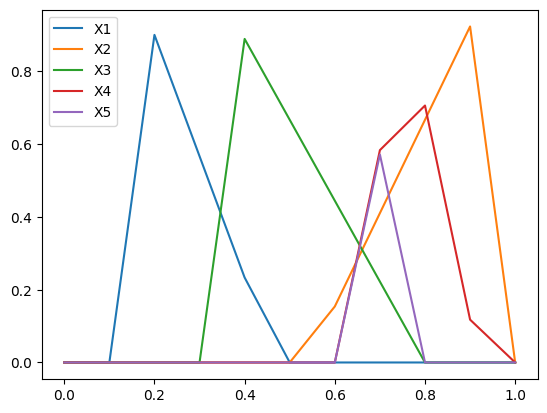

In [162]:
ax = plt.subplot(1,1,1)
for j in range(N):
    ax.plot(D, A[15,j], label= f"X{j+1}")
ax.legend()

In [163]:
o_center = np.round(rnd.rand(N),2)
o_min = np.round(rnd.rand(N)*o_center,2)
o_max = np.round(o_center + rnd.rand(N)*(1-o_center),2)
W = np.zeros((N, ticks))
for j in range(N):
    for t in range(ticks):
        if o_min[j] < D[t] < o_center[j]:
            W[j,t] = (D[t] - o_min[j]) / (o_center[j] - o_min[j])
        elif o_center[j] <= D[t] < o_max[j]:
            W[j,t] = (o_max[j] - D[t] ) / (o_max[j] - o_center[j])

#for j in range(N):
#    for t in range(1, ticks-1):
#        if o_min[j] < D[t] < o_center[j]:
#            W[j,t] = np.round(rnd.uniform(W[j,t-1], W[j,t+1]), 2)
#        elif o_center[j] <= D[t] < o_max[j]:
#            W[j,t] = np.round(rnd.uniform(W[j,t+1], W[j,t-1]), 2)

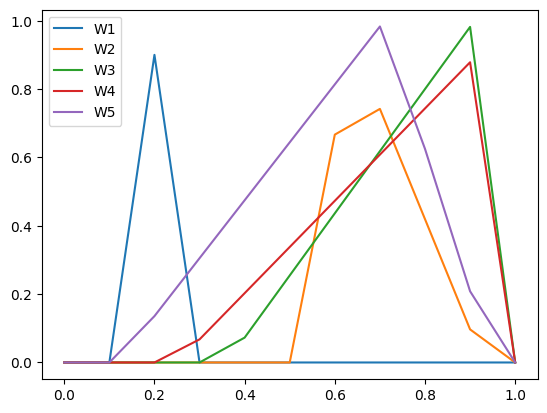

In [164]:
ax = plt.subplot(1,1,1)
for j in range(N):
    ax.plot(D, W[j], label= f"W{j+1}")
ax.legend()
plt.savefig("fig_w.png", dpi=600)
plt.show()

In [5]:
class FuzzyNumber:
    def __init__(self, polyline):
        self.polyline = np.array(polyline, np.float64)

    @staticmethod
    def get_ab( point1, point2 ):
        a = (point2[1]-point1[1])/(point2[0]-point1[0])
        b = point1[1] - a * point1[0]
        return a,b

    def get_membership(self, x):
        if x <= self.polyline[0,0]:
            return self.polyline[0,1]

        if x >= self.polyline[-1,0]:
            return self.polyline[-1,1]

        inds = np.where(self.polyline[:,0] == x)

        if len(inds)>0 and inds[0].size > 0:
            return self.polyline[inds[0][-1],1]

        inds = np.where((self.polyline[:-1,0] < x) & (self.polyline[1:,0] > x) )

        if len(inds)==0 or inds[0].size == 0:
            raise ValueError("Can not find point")

        a,b = self.get_ab( self.polyline[inds[0][0]], self.polyline[inds[0][0]+1] )
        return (a * x + b)

    def prep_scale(self, other):
        scale = np.union1d(self.polyline[:,0], other.polyline[:,0])
        scale_add = []
        for x1, x2 in zip(scale[:-1],scale[1:]):
            ys1 = self.get_membership(x1)
            ys2 = self.get_membership(x2)
            yo1 = other.get_membership(x1)
            yo2 = other.get_membership(x2)
            if (ys1 > yo1 and ys2 < yo2) or (ys1 < yo1 and ys2 > yo2):
                a_s,b_s = self.get_ab( [x1,ys1], [x2,ys2] )
                a_o,b_o = self.get_ab( [x1,yo1], [x2,yo2] )
                scale_add.append(round((b_o-b_s)/(a_s-a_o),5))
        return np.union1d(scale,scale_add)

    def __eq__(self, other):
        scale = np.union1d(self.polyline[:,0], other.polyline[:,0])
        return 1.0 - max(abs(self.get_membership(x) - other.get_membership(x)) for x in scale)

    def __ge__(self, other):
        scale = self.prep_scale(other)
        mh = np.array(np.meshgrid(scale,scale)).T.reshape(-1,2)
        return max( min(self.get_membership(x[0]),other.get_membership(x[1]))
                    for x in mh if x[0] >= x[1] )

    def __le__(self, other):
        return other >= self

    def general_operation(self, other,operation):
        scale = self.prep_scale(other)
        mh = np.array(np.meshgrid(scale,scale)).T.reshape(-1,2)
        y = np.round(operation(mh[:,0],mh[:,1]),5)
        mu = [ min(self.get_membership(x[0]),other.get_membership(x[1]))
                    for x in mh ]
        df = pd.DataFrame(dict(y=y, mu=mu))
        s = df.groupby('y')['mu'].max()
        a = self.polyline[0][0]
        b = self.polyline[-1][0]
        for yy in s.index:
            if yy == 0 and operation == np.divide:
                continue
            for s1 in np.linspace(a,b,1000):
                if abs(s1) < 0.00001 and operation == np.multiply:
                    continue
                elif operation == np.multiply: 
                        s2 = yy / s1
                elif operation == np.add: 
                        s2 = yy - s1
                elif operation == np.subtract: 
                        s2 = s1 - yy
                elif operation == np.divide: 
                        s2 = s1 / yy if yy != 0 else 0   
                m = min(self.get_membership(s1),other.get_membership(s2))
                if s[yy] < m:
                    s[yy] = m
        return FuzzyNumber(list(zip(s.index,s.values)))

    def __add__(self,other):
        return self.general_operation(other, np.add)

    def __sub__(self,other):
        return self.general_operation(other, np.subtract)

    def __mul__(self,other):
        return self.general_operation(other, np.multiply)

    def __truediv__(self,other):
        return self.general_operation(other, np.divide)

    def __repr__(self):
        spolyline = repr(self.polyline)
        spolyline = spolyline[spolyline.find('['):-1]
        return f"FuzzyNumber({spolyline})"

    def clip_membership( self, a ):
        b = self.polyline[:,1].reshape(-1,1)
        return FuzzyNumber(list(zip(self.polyline[:,0], np.min(np.insert(b,1,a,axis=1),axis=1))))

    def get_max_membership(self):
        return np.max(self.polyline[:,1])

    def logic_operation(self, other, operation):
        scale = self.prep_scale(other).reshape(-1,1)
        mus = np.apply_along_axis(self.get_membership, 1, scale)
        muo = np.apply_along_axis(other.get_membership, 1, scale)
        polyline = np.hstack((scale, operation(np.vstack((mus,muo)),axis=0).reshape(-1,1)))
        return FuzzyNumber(polyline)

    def __and__(self, other):
        return self.logic_operation(other, np.min)

    def __or__(self, other):
        return self.logic_operation(other, np.max)

    def defuzzification(self):
        a,b = self.get_ab(self.polyline[:-1].T, self.polyline[1:].T)
        s1 = np.sum(a * (self.polyline[1:,0]**3 - self.polyline[:-1,0]**3)/3.0 + \
             b * (self.polyline[1:,0]**2 - self.polyline[:-1,0]**2)/2.0)
        s2 =  np.sum(0.5 * (self.polyline[1:,0] - self.polyline[:-1,0]) * \
             (self.polyline[1:,1] + self.polyline[:-1,1]))
        return s1 / s2

In [ ]:
AA = []
for i in range(M):
    for j in range(3):
        print(i, j)
        num1 = FuzzyNumber(np.concatenate((D[:,np.newaxis], A[i,j][:, np.newaxis]),axis=1))
        num2 = FuzzyNumber(np.concatenate((D[:,np.newaxis], W[j][:, np.newaxis]),axis=1))
        if j == 0: 
            num3 = num1 * num2
        else:
            num = num1 * num2
            num3 = num3 + num
        df = pd.DataFrame(dict(y=np.round(num3.polyline[:,0],1), mu=num3.polyline[:,1]))
        s = df.groupby('y')['mu'].max()
        num3 = FuzzyNumber(np.concatenate((s.index.to_numpy()[:,np.newaxis], s.to_numpy()[:, np.newaxis]),axis=1))
    AA.append(num3.polyline)

In [423]:
AAA = np.array(AA)

In [425]:
np.save('my_rank.npy', AAA)

In [3]:
AAA = np.load('my_rank.npy')

In [3]:
AAA.shape

(30, 41, 2)

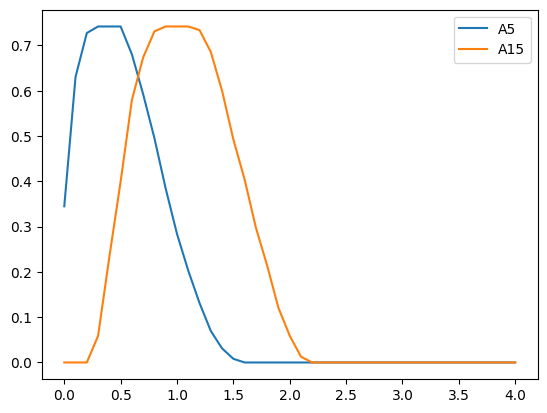

In [166]:
ax = plt.subplot(1,1,1)
ax.plot(AAA[5,:,0],AAA[5,:,1], label= "A5")
ax.plot(AAA[15,:,0],AAA[15,:,1], label= "A15")
ax.legend()
plt.savefig("fig_a.png", dpi=600)
plt.show()

In [167]:
FuzzyNumber(AAA[5]) >= FuzzyNumber(AAA[15])


0.6316663706995427

In [168]:
FuzzyNumber(AAA[5]) <= FuzzyNumber(AAA[15])

0.7419354838709679

In [6]:
R = np.eye(M,M)
for i in range(M):
    for j in range(M):
        if i != j:
            R[i,j] = np.round(FuzzyNumber(AAA[i]) >= FuzzyNumber(AAA[j]),2)

In [9]:
print(tabulate(R))

----  ----  ----  ----  -  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  -  ----  ----  ----  -  ----
1     0.67  0.67  0.67  0  0.67  0.67  0.67  0.67  0.67  0.57  0.67  0.5   0.67  0.56  0.67  0.67  0.67  0.5   0.67  0.67  0.64  0.67  0.66  0  0.67  0.22  0.5   0  0.67
0.67  1     0.67  0.67  0  0.67  0.65  0.64  0.67  0.67  0.57  0.67  0.5   0.67  0.56  0.67  0.62  0.64  0.5   0.67  0.64  0.64  0.67  0.59  0  0.66  0.22  0.5   0  0.67
0.67  0.67  1     0.74  0  0.74  0.74  0.67  0.74  0.74  0.57  0.74  0.5   0.67  0.56  0.74  0.73  0.73  0.5   0.74  0.74  0.64  0.67  0.71  0  0.74  0.22  0.5   0  0.74
0.67  0.67  0.74  1     0  0.74  0.74  0.67  0.74  0.74  0.57  0.74  0.5   0.67  0.56  0.74  0.74  0.74  0.5   0.74  0.74  0.64  0.67  0.74  0  0.74  0.22  0.5   0  0.74
0     0     0     0     1  0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0  0     

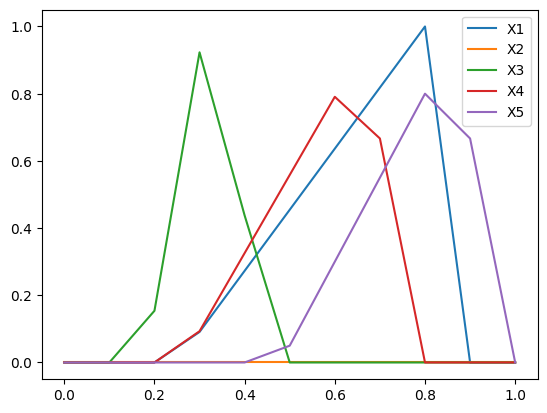

In [444]:
ax = plt.subplot(1,1,1)
for j in range(N):
    ax.plot(D, A[4,j], label= f"X{j+1}")
ax.legend()

In [445]:
A[4]

array([[0.        , 0.        , 0.        , 0.09090909, 0.27272727,
        0.45454545, 0.63636364, 0.81818182, 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.15384615, 0.92307692, 0.4375    ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.09302326, 0.3255814 ,
        0.55813953, 0.79069767, 0.66666667, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.05      , 0.3       , 0.55      , 0.8       , 0.66666667,
        0.        ]])

In [446]:
m_center[4]

array([0.8 , 0.97, 0.31, 0.69, 0.88])

In [7]:
for theta in np.arange(0.1,1.1,0.1):
    rr = np.zeros((M, M))
    for i in range(M):
        for j in range(M):
            if i != j and (R[i,j] >= theta):
                rr[i,j] = 1
    G = nx.from_numpy_array(rr, create_using = nx.DiGraph())
    print(theta, nx.is_directed_acyclic_graph(G))

0.1 False
0.2 False
0.30000000000000004 False
0.4 False
0.5 False
0.6 False
0.7000000000000001 False
0.8 True
0.9 True
1.0 True


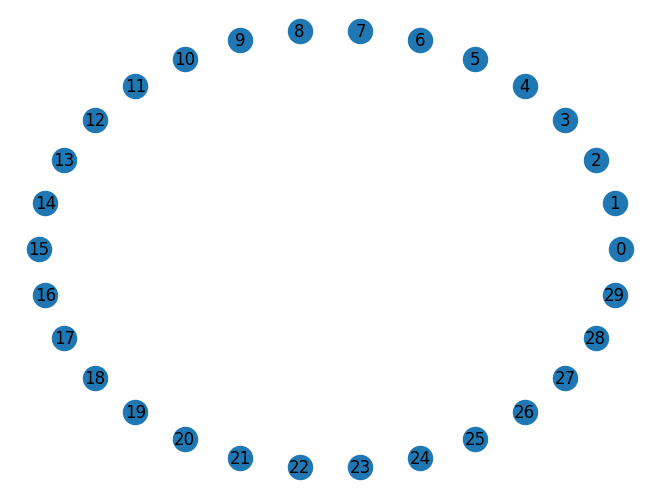

In [10]:
theta = 0.8
rr = np.zeros((M, M))
for i in range(M):
    for j in range(M):
        if i != j and R[i,j] >= theta:
            rr[i,j] = 1
G = nx.from_numpy_array(rr, create_using = nx.DiGraph())
#r = list(itertools.islice(nx.simple_cycles(G),100000))[65368]
#route_edges = [(r[n],r[n+1]) for n in range(len(r)-1)]
#route_edges.append((r[-1],r[0]))
#for i in range(M):
#    for j in range(M):
#        if (i,j) in G.edges and (j,i) in G.edges and (i,j) not in route_edges:
#            G.remove_edge(i,j)       
pos = nx.circular_layout(G)
nx.draw(G,with_labels=True, pos = pos)
#nx.draw_networkx_edges(G,pos=pos,edgelist=route_edges,edge_color = 'r', width=3)
#plt.savefig("ws1.png", dpi=600)
plt.show()

In [126]:
from pyscipopt import Model, quicksum

In [127]:
def kemeny_matrix(a):
    w = np.zeros((M,M))
    for k in range(NumExpert):
        for i in range(M):
            for j in range(M):
                if a[k,j,i] > 0 and i != j:
                    w[i,j] += 1
    model = Model() 
    model.hideOutput(True)
    x = {}
    for i in range(M):
        for j in range(M):
            if i != j:
                x[(i,j)] = model.addVar(f"x[{i},{j}]", vtype = 'B')
    for l in range(M):
        for i in range(M):
            for j in range(M):
                if i != j and j != l and i != l:
                    model.addCons(x[(i,j)] + x[(j,l)] + x[(l,i)] >= 1)
    for i in range(M):
        for j in range(M):
            if i != j:
                model.addCons(x[(i,j)] + x[(j,i)] == 1)
    model.setObjective(quicksum(w[i,j] * x[(i,j)] for i in range(M) for j in range(M) if i != j), "minimize")
    model.optimize()
    sol = model.getBestSol()
    if model.getStatus() != 'optimal':
        print(f"Ops! {model.getStatus()}")
        return np.zeros((M,M))
    # model.getSolvingTime()
    return np.array([[ int(sol[x[(i,j)]]) if i != j else 1 for j in range(M)] for i in range(M)])

In [150]:
A = nx.adjacency_matrix(G).todense()
NumExpert = 1
kms = kemeny_matrix(A[np.newaxis,:,:])

In [152]:
for i in range(M):
    kms[i,i] = 0
G = nx.from_numpy_array(kms, create_using = nx.DiGraph())
nx.is_directed_acyclic_graph(G), nx.is_weakly_connected(G)

(True, True)

In [147]:
rr = np.zeros((M, M))
for i in range(M):
    for j in range(M):
        if i != j and R[i,j] > R[j,i]:
            rr[i,j] = 1
G = nx.from_numpy_array(rr, create_using = nx.DiGraph())
nx.is_directed_acyclic_graph(G)

True

False


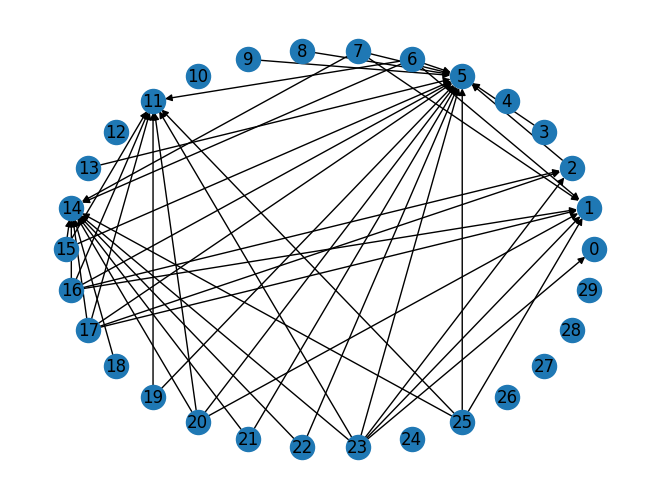

In [149]:
pos = nx.circular_layout(G)
print(nx.is_weakly_connected(G))
nx.draw(G,with_labels=True, pos = pos)